<a href="https://colab.research.google.com/github/alilumii/immunoinformatics_FBB/blob/main/1_HLA_Typing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Домашнее задание по HLA-типированию:

## С помощью nextflow-пайплайна [HLATyping](https://nf-co.re/hlatyping/2.1.0/):

### Подготовка среды для работы nextflow и hlatyping в Google Colaboratory:

*Код взят из [документации к nextflow](https://nf-co.re/docs/tutorials/google_colab/nf-core_colab_guide#setting-up-the-environment-in-google-colab):*

In [ ]:
# устанавливаем Java
!apt update
!apt install openjdk-17-jdk
!export JAVA_HOME=/usr/lib/jvm/java-17-openjdk-amd64
!export PATH=$JAVA_HOME/bin:$PATH
!source ~/.bashrc

In [ ]:
!wget -qO- https://get.nextflow.io | bash # скачивание Nextflow
!mv nextflow /usr/bin/nextflow
!chmod +x /usr/bin/nextflow
!nextflow -v # тестирование

In [ ]:
!pip install -q condacolab # скачиваем condacolab
import condacolab
condacolab.install()

In [ ]:
# добавляем каналы
!conda config --add channels bioconda
!conda config --add channels conda-forge
!conda config --set channel_priority strict

### Прогоняем hlatyping в Google Colab:

In [ ]:
# клонируем репозиторий
# в конфигах (папка conf/) меняем число CPU на 2, память - на 12 GB (можно даже меньше?)

! git clone https://github.com/nf-core/hlatyping.git

In [ ]:
# меняем backend, потому что конфликтует библиотека matplotlib Optitype и Google Colab

import os
os.environ['MPLBACKEND'] = 'Agg'

In [ ]:
# запускаем hlatyping

! nextflow run hlatyping/main.nf -profile conda,test --outdir hlatyping-results

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)

 N E X T F L O W   ~  version 25.10.0

Launching `hlatyping/main.nf` [intergalactic_goldstine] DSL2 - revision: 770bb6b844


------------------------------------------------------
                                        ,--./,-.
        ___     __   __   __   ___     /,-._.--~'
  |\ | |__  __ /  ` /  \ |__) |__         }  {
  | \| |       \__, \__/ |  \ |___     \`-._,-`-,
                                        `._,._,'
  nf-core/hlatyping 2.1.0
------------------------------------------------------
Input/output options
  input                     : https://raw.githubusercontent.com/nf-core/test-datasets/hlatyping/samplesheets/samplesheet_bam.csv
  outdir                    : hlatyping-results

Institutional config options
  config_profile_name       : Test profile
  config_profile_description: Minimal test dataset to check pipeline function

Generic options
  multiqc_logo              : /content/h

In [ ]:
# визуализация результатов hlatypng

import pandas as pd

res = pd.read_csv('/content/hlatyping-results/optitype/SAMPLE_PAIRED_END_BAM/SAMPLE_PAIRED_END_BAM_result.tsv', sep='\t')
print(res)

   Unnamed: 0       A1       A2       B1       B2       C1       C2   Reads  \
0           0  A*01:01  A*01:01  B*08:01  B*57:01  C*06:02  C*07:01  1129.0   

   Objective  
0   1108.678  


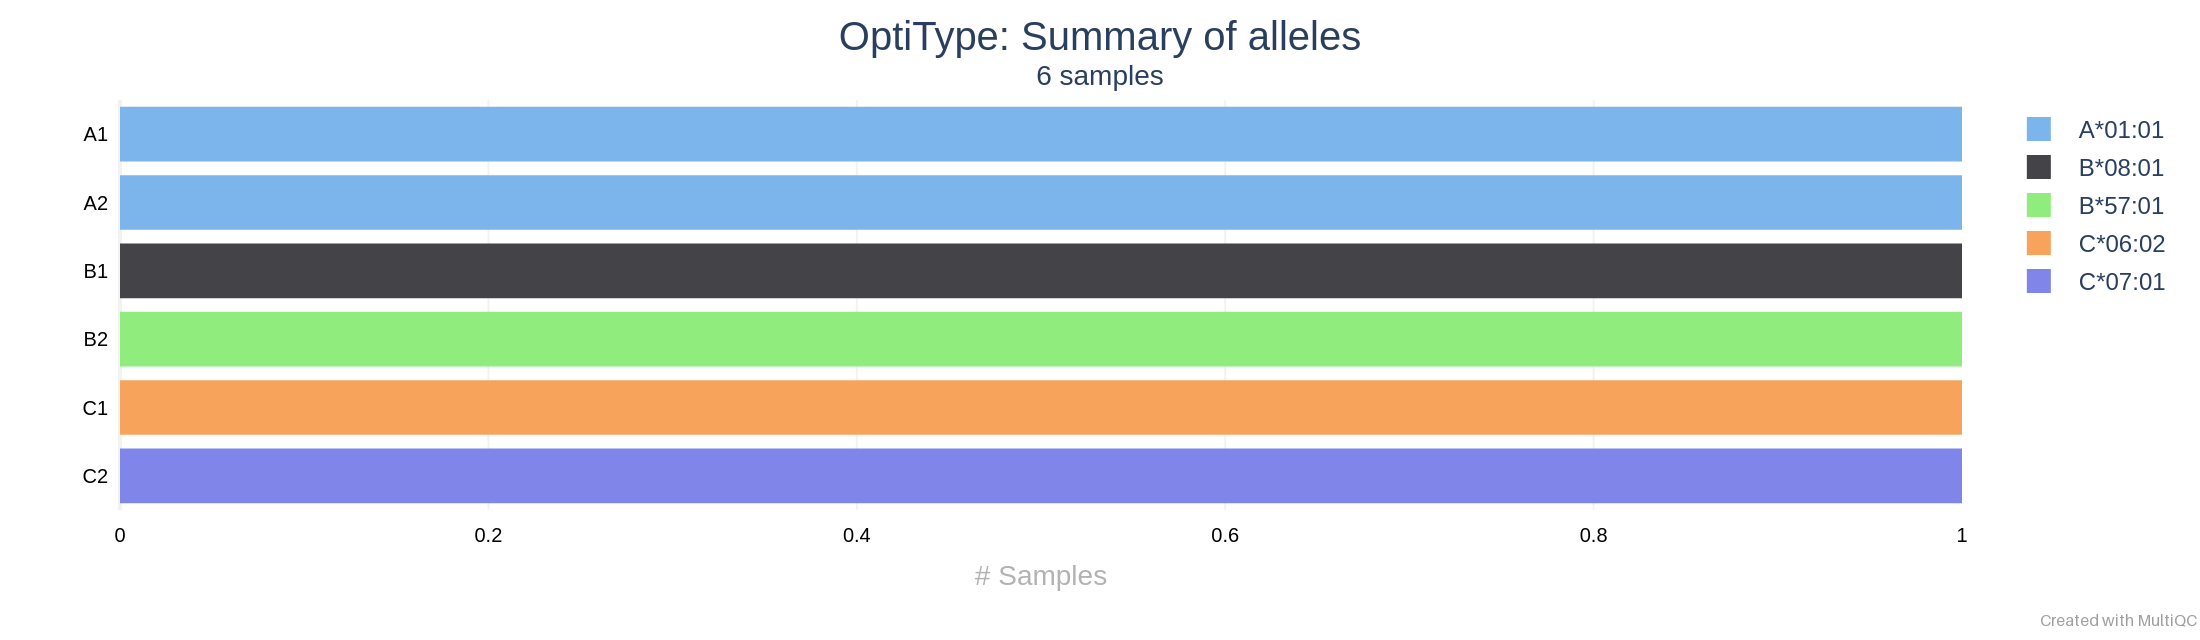

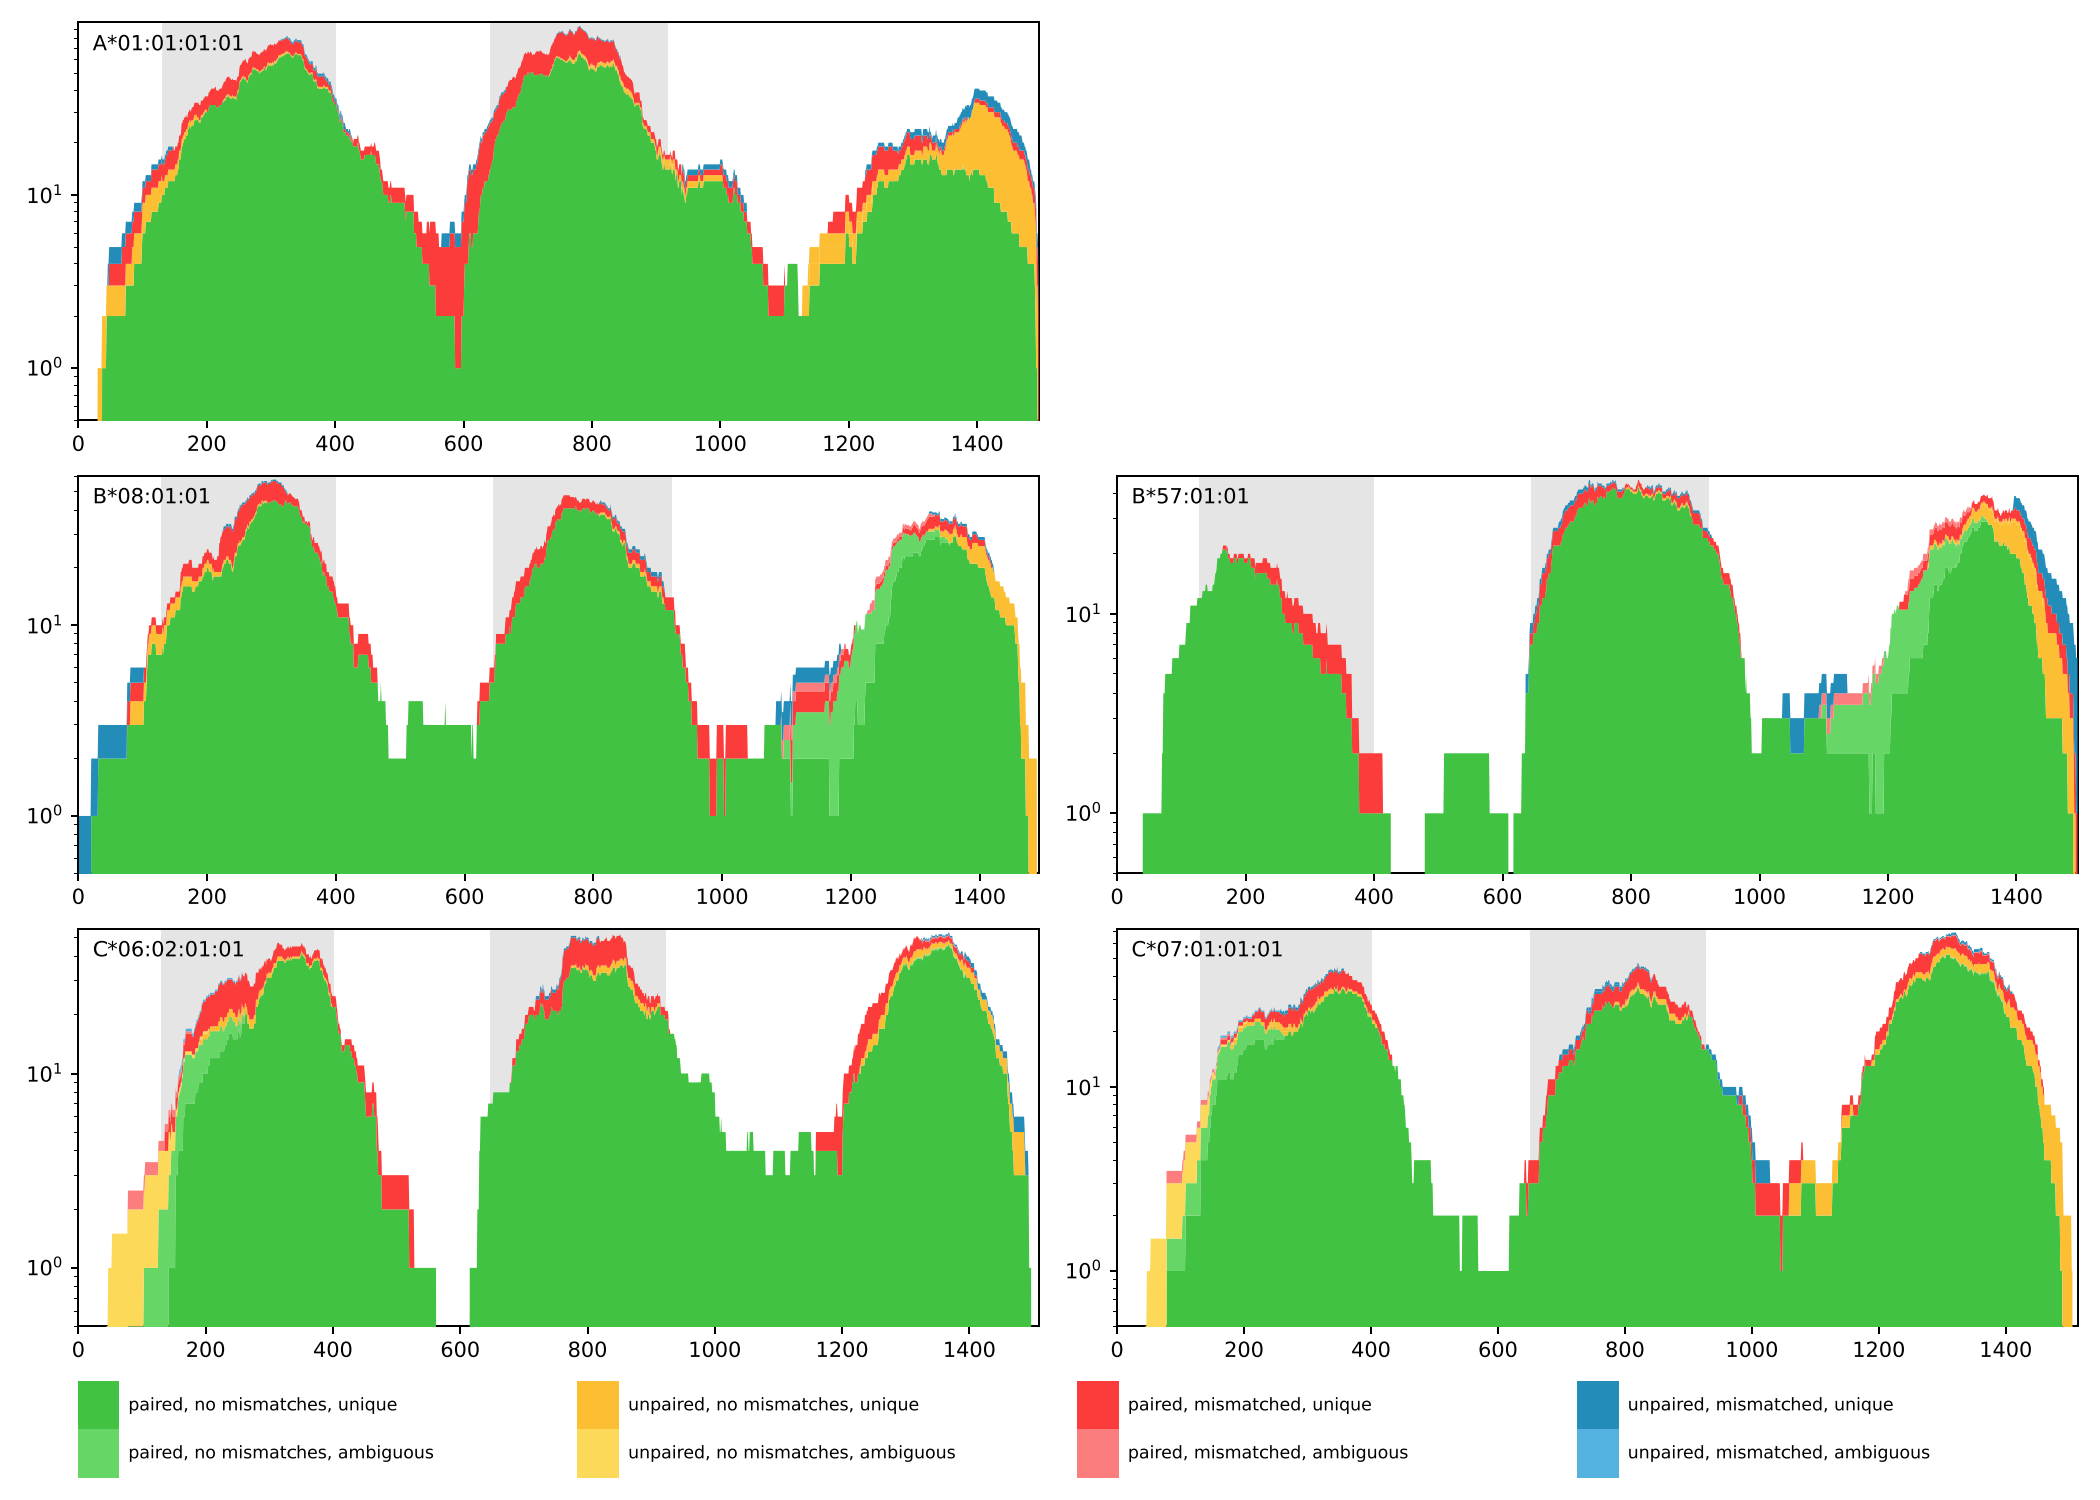

Можно скачать всю выдачу hlatypng в виде zip-архива:

In [ ]:
!zip -r /content/hlatyping-res.zip /content/hlatyping-results/

In [ ]:
from google.colab import files
files.download("/content/hlatyping-res.zip")

## С помощью классических алгоритмов:

### Подготовка пакетов и данных:

In [ ]:
# скачиваем из github / или с помощью conda BWA-MEM (т.к. длина прочтений = 100)
# скачиваем репозиторий с BBTools, где находится скрипт repair.sh (нужен для чистки прочтений)
# скачиваем из github / или с помощью conda Samtools

cd /usr/local/bin/
git clone https://github.com/lh3/bwa.git
cd /bwa; make # устанавливаем BWA-MEM
cd /usr/local/bin/
sudo git clone https://github.com/bbushnell/BBTools.git
git clone https://github.com/samtools/samtools.git

In [ ]:
# В папку с bwa:
# 1) Скачиваем референс из IMGT
wget https://ftp.ebi.ac.uk/pub/databases/ipd/imgt/hla/hla_nuc.fasta
# 2) Скачиваем прочтения (парно-концевые) из тестового датасета для работы hlatyping
wget https://raw.githubusercontent.com/nf-core/test-datasets/hlatyping/fastq/NA11995_SRR766010_1_fished.fastq.gz
wget https://raw.githubusercontent.com/nf-core/test-datasets/hlatyping/fastq/NA11995_SRR766010_2_fished.fastq.gz

### Этапы анализа:


1.   Чистка прочтений;
2.   Индексация референса и выравнивание с помощью BWA-MEM;
3.   Перевод в bam-формат и расчёт глубины покрытия.



In [ ]:
# чистим прочтения

BBTools/repair.sh in1=bwa/NA11995_SRR766010_1_fished.fastq.gz in2=bwa/NA11995_SRR766010_2_fished.fastq.gz out1=bwa/test_1_fixed.fastq.gz out2=bwa/test_2_fixed.fastq.gz

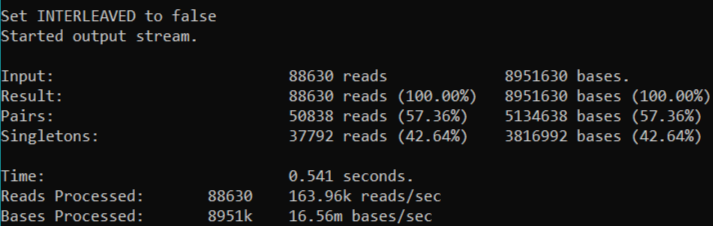

In [ ]:
# индексиируем референс
cd /usr/local/bin/bwa
bwa index hla_ref.fasta # пришлось закапываться в PATH, конечно, чтобы заработало

In [ ]:
# выравнивание с помощью BWA-MEM
bwa mem hla_nuc.fasta test_1_fixed.fastq.gz test_2_fixed.fastq.gz | gzip -3 > aln-pe.sam.gz

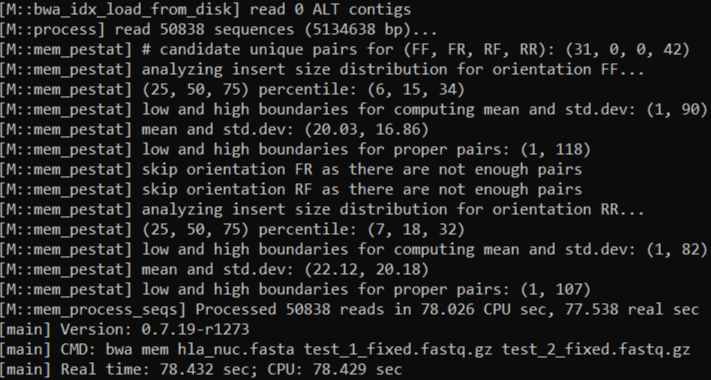

*А дальше samtools отказался устанавливаться в силу слабого Wi-Fi, поэтому дальше работали в [Galaxy](https://usegalaxy.org/) (благо, там есть Samtools).*

Для расчёта глубины покрытия нам нужен отсортированный bam-файл (по координатам), поэтому нам нужно sam-файл с выравниванием перевести в bam-формат с помощью samtools view:

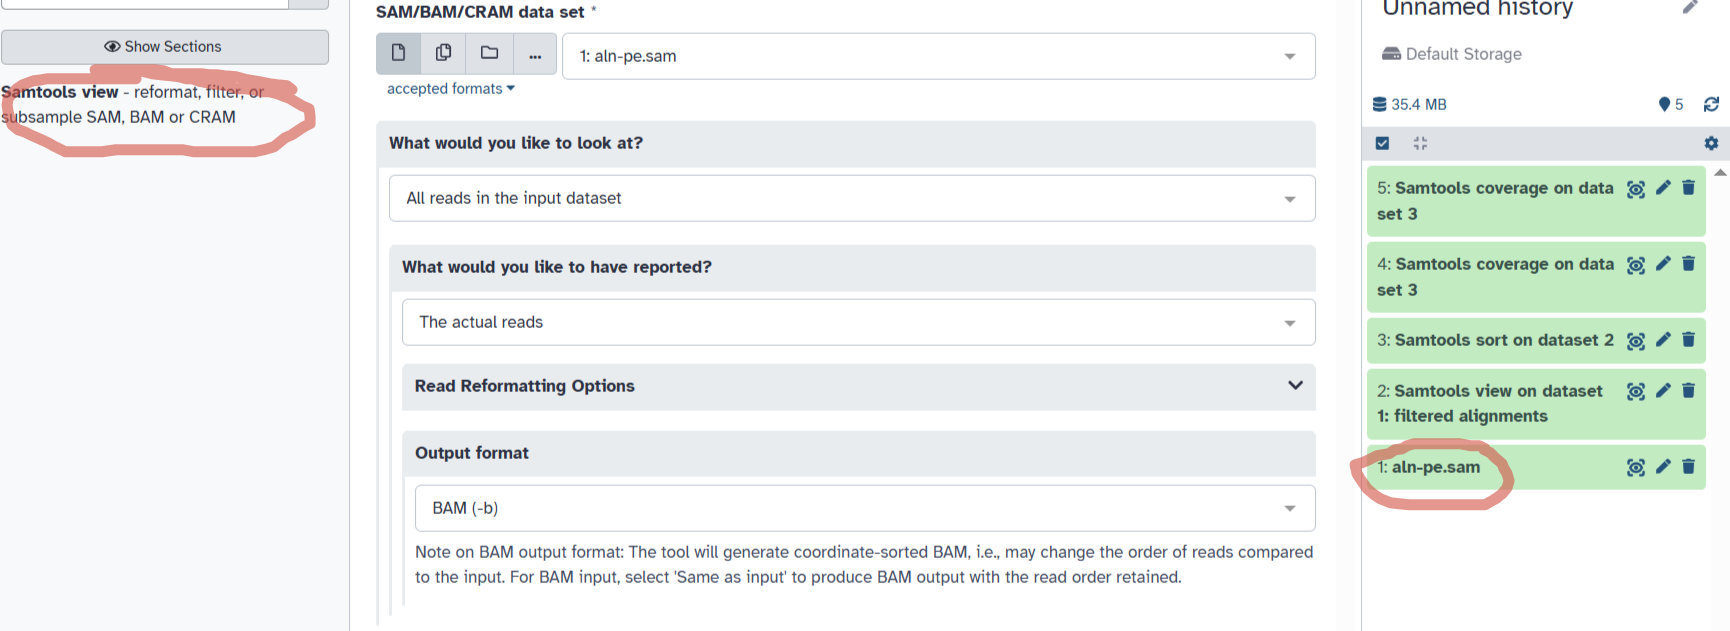

Сортируем с помощью samtools sort:

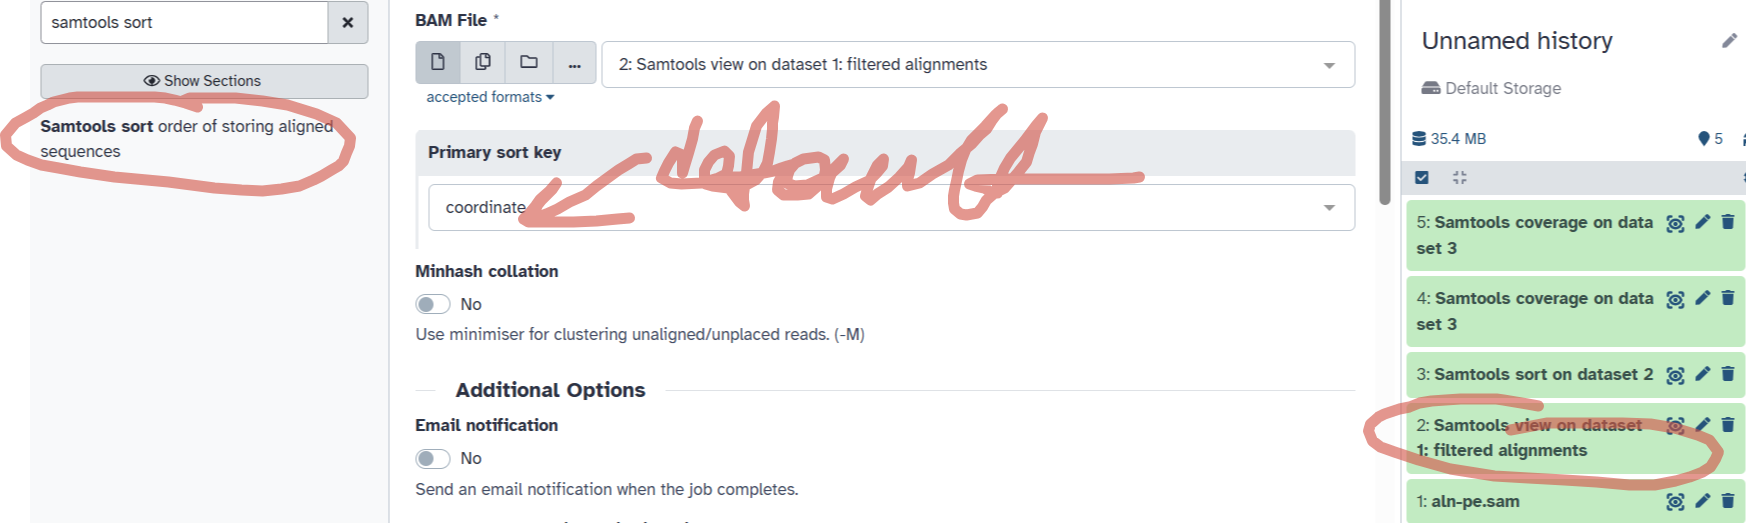

Считаем глубину покрытия с помощью samtools coverage:

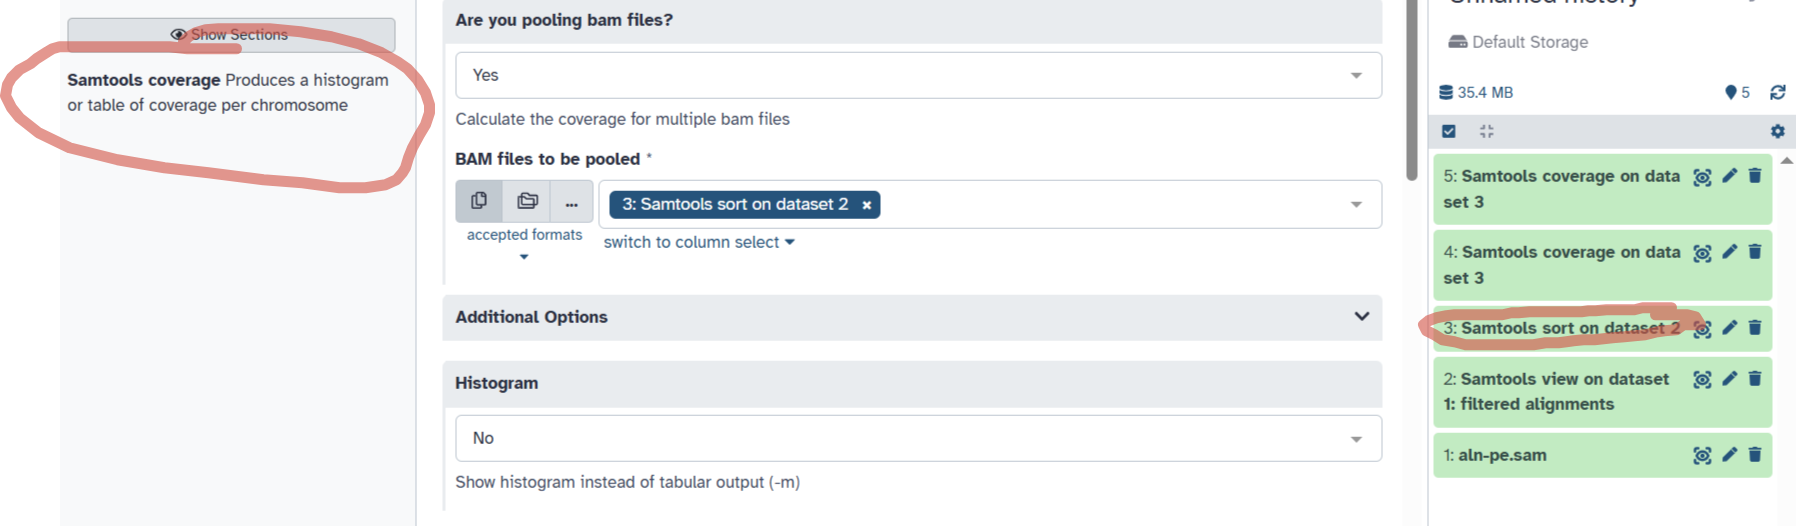

Табличку можно скачать и внутри неё сделать преобразования (вытащить названия аллелей, сортировка и т.д.).

In [71]:
# загружаем табличку средствами Python

bwa_res = pd.read_csv('hla_test.csv')
bwa_res

,AlleleID,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq
0,HLA18604,1,266,77,196,73.6842,26.2180,36.1,29.0
1,HLA18592,1,196,49,186,94.8980,23.8214,34.2,0.0
2,HLA18591,1,196,48,196,100.0000,23.1990,33.9,0.0
3,HLA01718,1,1163,203,350,30.0946,14.7610,35.0,26.8
4,HLA02658,1,1093,167,1018,93.1382,13.2434,35.3,25.1
...,...,...,...,...,...,...,...,...,...
44018,HLA30842,1,1151,0,0,0.0000,0.0000,0.0,0.0
44019,HLA30983,1,1152,0,0,0.0000,0.0000,0.0,0.0
44020,HLA31739,1,954,0,0,0.0000,0.0000,0.0,0.0
44021,HLA36677,1,1152,0,0,0.0000,0.0000,0.0,0.0


In [ ]:
# подгружаем список аллелей
! wget ftp://ftp.ebi.ac.uk/pub/databases/ipd/imgt/hla/Allelelist.txt

In [70]:
alleles = pd.read_csv('Allelelist.txt') # удалим из начала файла шапку со служебными строками
alleles

,AlleleID,Allele
0,HLA00001,A*01:01:01:01
1,HLA02169,A*01:01:01:02N
2,HLA14798,A*01:01:01:03
3,HLA15760,A*01:01:01:04
4,HLA16415,A*01:01:01:05
...,...,...
44023,HLA38075,TAP2*02:01:04
44024,HLA38025,TAP2*02:02
44025,HLA38029,TAP2*02:03
44026,HLA38159,TAP2*02:04


In [79]:
# соединяем две таблички

alleles_cov = pd.merge(alleles, bwa_res, how="inner", on="AlleleID")
alleles_cov

,AlleleID,Allele,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq
0,HLA00001,A*01:01:01:01,1,1098,0,0,0.00000,0.000000,0.0,0.00
1,HLA02169,A*01:01:01:02N,1,1098,0,0,0.00000,0.000000,0.0,0.00
2,HLA14798,A*01:01:01:03,1,1098,4,306,27.86890,0.367942,33.5,0.00
3,HLA15760,A*01:01:01:04,1,1098,1,88,8.01457,0.080146,37.6,0.00
4,HLA16415,A*01:01:01:05,1,1098,2,179,16.30240,0.163024,32.3,0.00
...,...,...,...,...,...,...,...,...,...,...
44018,HLA38075,TAP2*02:01:04,1,2112,20,945,44.74430,0.742898,34.7,0.00
44019,HLA38025,TAP2*02:02,1,2112,8,515,24.38450,0.368371,33.2,0.00
44020,HLA38029,TAP2*02:03,1,2112,15,945,44.74430,0.630208,33.4,1.33
44021,HLA38159,TAP2*02:04,1,2112,9,600,28.40910,0.383049,36.9,0.00


In [95]:
# отсортируем по количеству прочтений, выпавших на конкретный участок HLA
alleles_sorted = alleles_cov.sort_values(by=['numreads'], ascending=False)
alleles_sorted.head(10)

,AlleleID,Allele,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq
2818,HLA01718,A*03:01:01:02N,1,1163,203,350,30.09460,14.76100,35.0,26.800
31353,HLA27609,DRB1*10:38,1,855,189,71,8.30409,12.29470,36.4,50.000
29408,HLA02658,K*01:01:01:02,1,1093,167,1018,93.13820,13.24340,35.3,25.100
29414,HLA02655,L*01:01:01:01,1,1096,164,1019,92.97450,12.27460,34.6,0.000
29417,HLA02661,L*01:01:02,1,1096,163,1020,93.06570,11.06480,34.1,0.166
29415,HLA02662,L*01:01:01:02,1,1096,155,1010,92.15330,10.86130,35.2,0.000
29416,HLA02663,L*01:01:01:03,1,1096,155,984,89.78100,10.50090,34.8,0.000
191,HLA13620,A*01:01:71,1,1098,127,215,19.58110,7.33607,34.4,0.677
10876,HLA00163,B*15:01:01:02N,1,1208,122,329,27.23510,8.60099,32.7,36.800
25601,HLA23631,C*07:797N,1,1101,118,125,11.35330,7.80381,33.9,0.000


In [97]:
# сравним с выдачей HLATyping для каждого типа аллеля:

# для типа "А":
alleles_sorted[alleles_sorted['Allele'].str.startswith('A')].head(3)

,AlleleID,Allele,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq
2818,HLA01718,A*03:01:01:02N,1,1163,203,350,30.0946,14.76100,35.0,26.800
191,HLA13620,A*01:01:71,1,1098,127,215,19.5811,7.33607,34.4,0.677
4221,HLA20170,A*11:303,1,1098,108,128,11.6576,7.11840,36.0,13.000


In [98]:
# для типа "B":
alleles_sorted[alleles_sorted['Allele'].str.startswith('B')].head(3)

,AlleleID,Allele,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq
10876,HLA00163,B*15:01:01:02N,1,1208,122,329,27.23510,8.600990,32.7,36.80
16695,HLA42424,B*44:429N,1,1089,18,146,13.40680,1.213040,35.6,4.44
10551,HLA20105,B*13:123Q,1,1113,12,104,9.34412,0.604672,34.7,3.42


In [99]:
# для типа "C":
alleles_sorted[alleles_sorted['Allele'].str.startswith('C')].head(3)

,AlleleID,Allele,startpos,endpos,numreads,covbases,coverage,meandepth,meanbaseq,meanmapq
25601,HLA23631,C*07:797N,1,1101,118,125,11.35330,7.80381,33.9,0.0
24269,HLA17976,C*07:02:01:17N,1,1211,75,298,24.60780,5.95871,33.8,43.4
22191,HLA01451,C*04:09L,1,1197,44,104,8.68839,2.56224,36.2,0.0


Ну, как будто бы совсем разные результаты вышли...